# COGS 108 - Final Project

## Overview
Fill in your overview here<br>
Names:<br>
> 1) Marco Aceves<br>
2) Karim Dabboussi<br>
3) Brent Kimura<br>
4) Amanda Bustamante<br>
5) Stjepan Kilic<br>

## Research Question
What variables contribute to car accidents in San Diego specifically what variables affect how dangerous an accident will be?

## Background and Prior Work
By studying and analyzing a live traffic map of downtown San Diego (source 3), we are able to see a significant amount of congestion in the Mission Hills, Gaslamp, and Coronado areas of the metroplex. These high density zones that undergo frequent use, along with colliding one way streets make downtown San Diego an accident prone area. We are working with a dataset from a practical point of view for this problem is one in which the data itself is specific enough to make evident what factors will increase the likelihood of an accident occurring. The variables that are contained within the  dataset specify the location, date, time, weather conditions, driver behavior (intoxication), outcome of accidents; which took data cleaning and the use of API to gather more information about the coordinates of car accidents and the weather data. Our data contained an ideal amount of observations, a dataset of an ideal nature should have enough observations to accurately pinpoint locations of accidents and show a general trend. Hence, we found data with around 20,000 or more data observations, in the context of San Diego it would give a good scope of data to analyze. Though there are numerous accidents reported to the police each year, there are many that are not reported for many reasons. Due to these circumstances, there is a possibility we will miss data that could potentially affect our results significantly. Our data includes traffic collisions in San Diego gathered from the California Highway Patrol (SDPD) reports (source 1), and weather data from The National Weather Service (source 5). Ideally, we want to store and organize these sets of data in separate csv files.<br>
References (include links):<br>
> 1) https://data.sandiego.gov/datasets/police-collisions/<br>
2) https://www.caraccidentlawyer-sandiego.com/Blog/2017/08/The-Top-10-Most-Accident-Prone-Roads-in-San-Dieg.aspx<br>
3) https://www.nbcsandiego.com/traffic/<br>
4) https://www.transportation.gov/data<br>
5) https://www.weather.gov/help-past-weather<br>
6) https://www.weather.gov/documentation/services-web-api# <br>

## Hypothesis
Locations such as high traffic areas, days surrounding holidays, early mornings, late nights, rainy weather, high temperatures, poor road conditions, and changes in driver behavior due to these variables increase the likelihood of car accidents in San Diego. Low traffic areas, holidays, times in the middle of the day, clear weather, mild temperatures, and good road conditions will decrease the likelihood of car accidents in San Diego.

## Dataset(s)
Dataset Name: pd_colissions_data_.csv<br>
Link to the dataset: https://data.sandiego.gov/datasets/police-collisions/<br>
Number of observations: 20,000+<br>

The data set includes historical data of traffic accidents in San Diego from the year 2015 to date. The data includes more than 20,000 observations of the time and date of when the incident occurred, the report id (case number), the police beat which will be removed from our data set for protection of privacy, the address of where the accident occured, the data included the violation number with a violation description, finally it includes the number of people injured or killed during the incident. 
 

## Setup

In [1]:
import pandas as pd
import numpy as np
import os
import folium
from folium import plugins
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import scipy.stats as stats

## Data Cleaning
The Data Cleaning was done in two steps, the first steps involved dropping unnecessary rows, and combining a few rows. However in order to get geographic coordinates an api called geopy was used. The problem with geopy is that it got coordinates in a very slow way, requiring the process to run multiple times to prevent timeouts. This took a week or two to fully complete. By the time we realized this we realized that we needed to make a new notebook, but the data had partially been cleaned from the initial data frame so we had to import the new dataframe that was cleaned. Inorder to prevent runtime issues, the original code for getting the coordinates and any other issues has been preserved in markdown.<br>

In [1]:<br>
import pandas as pd<br>
import numpy as np<br>
import os<br>
import geopy<br>
from geopy.geocoders import Nominatim<br>
from geopy.extra.rate_limiter import RateLimiter<br>

In [2]:<br>
df = pd.read_csv('pd_collisions_datasd_v1.csv')<br>
df["address_of_traffic_accident"] = df["address_number_primary"].astype('str') + df["address_pd_primary"] + " " + df["address_road_primary"] + " " + df["address_sfx_primary"]<br>
df["address_if_intersection"] = df["address_pd_intersecting"].astype('str') + df["address_name_intersecting"] + " " + df["address_sfx_intersecting"]<br>
df = df.drop(columns=['address_number_primary', 'address_pd_primary', 'address_road_primary', 'address_sfx_primary'])<br>
df = df.drop(columns=['address_pd_intersecting','address_name_intersecting','address_sfx_intersecting','police_beat'])<br>
cols = list(df.columns)<br>
a, b = cols.index('violation_section'), cols.index('address_of_traffic_accident')<br>
cols[b], cols[a] = cols[a], cols[b]<br>
df = df[cols]<br>
fatal = df['killed'].sum()<br>
nonFatal = df['injured'].sum()<br>
df.shape<br>

Out[ ]:<br>
(20484, 10)<br>

In [3]:<br>
geolocator = Nominatim(user_agent="COGS108_Traffic_DataScience")<br>
location = geolocator.geocode("3100 BERGER AVENUE San Diego, CA")<br>
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)<br>
df['address_of_traffic_accident'] = df['address_of_traffic_accident'] + " " + ",San Diego, CA";<br>
dftest = df.iloc[20001:20485].copy()<br>
dftest['coordinates'] = df['address_of_traffic_accident'].apply(geocode).apply(lambda x: (x.latitude, x.longitude))<br>
dftest['coordinates'] = geolocator.geocode(dftest['address_of_traffic_accident'])<br>
geolocator = Nominatim(user_agent="COGS108_Traffic_DataScience",timeout=30)<br>

geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)<br>
dftest['location'] = dftest['address_of_traffic_accident'].apply(geocode)<br>

dftest['point'] = dftest['location'].apply(lambda loc: tuple(loc.point) if loc else None)<br>

In [4]:<br>
dftest<br>

dftest.to_csv('dffile14.csv', index=False)<br>

df.shape<br>

In [2]:
%matplotlib inline

df = pd.read_csv('pdData.csv')
df2 = pd.read_csv('weatherData.csv')
result_df = df.copy()
result_df = result_df.drop_duplicates(keep='first')
result_df.reset_index(drop=True)
result_df = result_df[result_df['point'].notna()]
downTown = [32.715736, -117.161087]

def nightDay(string):
    #grab the time from a column
    string = string[-5:]
    string = string.strip()
    # if time is not 00:00 format add a 0 onto it
    if len(string) == 4:
        string = "0" + string
    #classification of times using military time
    if len(string) == 5:
        if int(string[:2]) >= 5 and int(string[:2]) <= 11:
            return "morning"
        elif int(string[:2]) >= 12 and int(string[:2]) <= 16:
            return "afternoon"
        elif int(string[:2]) >= 17 and int(string[:2]) <= 20:
            return "evening"
        else:
            return "night"
def binaryDayNight(string):
    #grab the time from a column
    string = string[-5:]
    string = string.strip()
    # if time is not 00:00 format add a 0 onto it
    if len(string) == 4:
        string = "0" + string
    #classification of times using military time
    if len(string) == 5:
        if int(string[:2]) >= 5 and int(string[:2]) <= 17:
            return 0 # might need to change to 1 
        else:
            return 1 # might need to change to 0
def rainfallLog(df):
    updated_df = df
    updated_df["rainfall"] = df["rainfall"]#Copies the old df
    list1 = updated_df["rainfall"].tolist()     
    i = 0
    while i < len(list1):
        if list1[i] > 0:
            list1[i] = 1
        else:
            list1[i] = 0
        i = i+1
    return list1
def grabDatePrefix(string):
    string = str(string)
    if(len(string) == 10):
        return string[:5]
    elif(len(string) == 9):
        return string[:4]
    elif(len(string) == 8):
        return string[:3]
def killed(string):
    if int(string) > 0:
        return 1
    else:
        return 0
def getDate(string):
    #extracts date from column
    string = string.strip()
    string = string.split(" ", 1)[0]
    string = string[:10]
    string = string.strip()
    return string
def comparatorDate(date1,date2):
    date1 = date1.strip()
    date2 = date2.strip()
    if date1 == date2:
        return True
    else:
        return False
def tupleAccess(data):
        #grabs tuple from column to get
        #longitude and lagitude format
        data = data.split(',')
        element1 = data[0]
        element1 = element1[1:].strip()
        element2 = data[1].strip()
        holder = [element1,element2]
        #returns a list
        return holder

def sanDiegoMap(df,start,end,zoom,long,lat):
    map = folium.Map(location=[long, lat],zoom_start=zoom)
    for i in range(start, end):
        point = [df['long'].loc[i],df['lat'].loc[i]]
        folium.Marker(location=[point[0],point[1]], popup=df['date_time'][i]).add_to(map)
    return map

In [3]:
result_df.head()

,report_id,date_time,address_of_traffic_accident,violation_type,charge_desc,injured,killed,hit_run_lvl,violation_section,address_if_intersection,location,point
0,180698,1/18/2018 0:01,"500 SEA WORLD DRIVE ,San Diego, CA ,San Diego...",VC,VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR ...,0,0,MISDEMEANOR,22350,,"SeaWorld San Diego, 500, Sea World Drive, Loma...","(32.7659778, -117.226626467006, 0.0)"
1,180716,1/18/2018 0:01,"7600 PALMILLA DRIVE ,San Diego, CA ,San Diego...",VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR,MISC-HAZ,,"7600, Palmilla Drive, La Jolla Colony, Univers...","(32.863052, -117.224988, 0.0)"
2,180886,1/18/2018 0:01,"9300 CLAIREMONT MESA BOULEVARD ,San Diego, CA...",VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR,MISC-HAZ,,"Clairemont Mesa Boulevard, Tierrasanta, San Di...","(32.8336953, -117.1195042, 0.0)"
3,180756,1/18/2018 0:01,"5900 BALBOA AVENUE ,San Diego, CA ,San Diego,...",VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR,MISC-HAZ,,"Balboa Avenue, Pacific Beach, San Diego, San D...","(32.8075226, -117.2125742, 0.0)"
5,180815,1/18/2018 7:53,"3500 BARNETT AVENUE ,San Diego, CA ,San Diego...",VC,VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR ...,1,0,NaN,22350,,"3500, Barnett Avenue, Loma Portal, Old Town, S...","(32.745185, -117.198612, 0.0)"


In [4]:
result_df['day/night'] = result_df['date_time'].apply(nightDay)
result_df = result_df.drop(columns={'address_if_intersection','location',
                                    'address_of_traffic_accident','location','violation_section','violation_type'},axis=1)
result_df.reset_index(drop=True, inplace=True)
#dropped unneccesary rows that wont be used in the analysis
#more rows will be added to the dataframe later on
result_df.head()

,report_id,date_time,charge_desc,injured,killed,hit_run_lvl,point,day/night
0,180698,1/18/2018 0:01,VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR ...,0,0,MISDEMEANOR,"(32.7659778, -117.226626467006, 0.0)",night
1,180716,1/18/2018 0:01,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR,"(32.863052, -117.224988, 0.0)",night
2,180886,1/18/2018 0:01,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR,"(32.8336953, -117.1195042, 0.0)",night
3,180756,1/18/2018 0:01,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR,"(32.8075226, -117.2125742, 0.0)",night
4,180815,1/18/2018 7:53,VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR ...,1,0,NaN,"(32.745185, -117.198612, 0.0)",morning


In [5]:
#Important Note about df2 it was a dataframe that we created using another api to get the weather, but it took a longtime
#to compute like folium and only relevant data was extracted.
df2.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,1/1/2018,18,12,0,8.7,1,1,97,4:54 PM,6:13 AM,...,15,9,15,70,0.0,1020,18,10,277,6
1,1/2/2018,21,13,0,8.7,1,1,100,6:00 PM,7:17 AM,...,17,11,16,58,0.0,1020,21,10,241,6
2,1/3/2018,19,14,0,3.8,1,1,89,7:08 PM,8:14 AM,...,17,6,48,57,0.0,1018,19,10,203,3
3,1/4/2018,20,14,0,8.7,1,1,81,8:16 PM,9:04 AM,...,17,10,12,67,0.0,1020,20,10,253,6
4,1/5/2018,20,15,0,8.7,1,1,74,9:22 PM,9:49 AM,...,17,15,20,79,0.0,1021,20,10,252,9


In [6]:
result_df['temp'] = np.nan
result_df['rainfall'] = np.nan
df2 = df2.set_index('date_time')

In [7]:
i = 0
#adds the weather data to the data frame from the weather df
while i < len(result_df):
        try:
            location = getDate(result_df['date_time'].loc[i])
            result_df['temp'].loc[i] = df2['tempC'].loc[str(location)]
            result_df['rainfall'].loc[i] = df2['precipMM'].loc[str(location)]
            i += 1
        except KeyError:
            i += 1
            continue

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
result_df.reset_index(drop=True, inplace=True)
result_df['long'] = np.nan
result_df['lat'] = np.nan
i = 0
while i < len(result_df):
    point = tupleAccess(result_df['point'].loc[i])
    result_df['lat'].loc[i] = point[0]
    result_df['long'].loc[i] = point[1]
    i += 1

## Data Analysis & Results
Once our data was cleaned of unnecessary extraneous variables, we were left with the number of accidents each day in the past two years, whether the accidents were fatal, what time of day the accidents occurred at,  how much rainfall occurred each day, and the temperature of each day. 

### Map of San Diego

In [9]:
result_df = result_df[result_df['long'].notna()]
mapSD = sanDiegoMap(result_df,0,1,14,downTown[0],downTown[1])
dfMap = result_df.sample(n = 5000)

#here we randomly sample a heat map to see 
#where the intenisty of accidents is most focused in down town san diego.
heat_data = [[row['lat'],row['long']] for index, row in dfMap.iterrows()]

folium.Marker(
    location=[32.707138, -117.162498],
    popup='Convention Center',
    icon=folium.Icon(color='black')
).add_to(mapSD)

# Plot it on the map
HeatMap(heat_data).add_to(mapSD)
#result_df.to_csv('trafficPDSDAccidents_Cleaned.csv')

#IF THIS DOSENT DISPLAY, YOU CAN VIEW IT ON THE HTML VERSION IN THE REPO
mapSD

Here we found the used the addresses of each accident and inputted them into a geospatial api as a latitude and longitude value. We then specified that we wanted a heat map to display. The more common the location is for accidents, the more red the color is. Looking at the graph we noticed that most accidents occurred in and around San Diego while there were a few outliers in Camp Pendleton and Anza Borrego Desert. Traffic accidents also become much more common as you get closer to downtown San Diego as there is more traffic due to frequent traffic lights and more urbanization occurring in this area.

### Time of Day that Accidents Occured

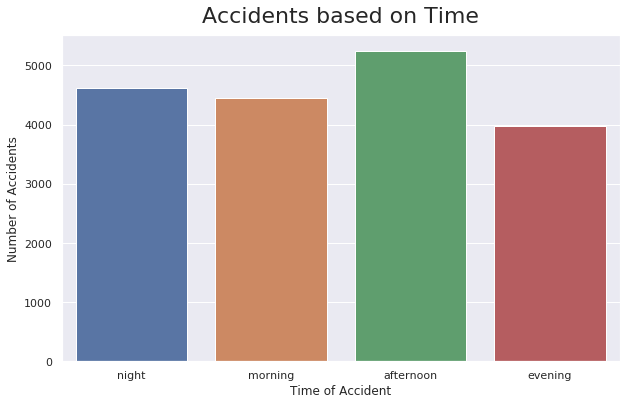

In [35]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="day/night", data=result_df)
ax.set_ylabel('Number of Accidents')
ax.set_xlabel('Time of Accident')
ax.set_title("Accidents based on Time", y=1.02, fontsize=22)
sns.set(style="darkgrid")

Here, we classified the time each accident occurred and classified it as morning, afternoon, evening, and night. As we can see, there is a large increase in traffic accidents in the afternoon. This can be attributed to the fact that most people get off of work in the afternoon and the rush hour traffic leads to more accidents than other times of day more likely because of the increased volume of people on the road.

### Rain vs. No Rain

Text(0.5, 1.02, 'Average amount of daily accidents')

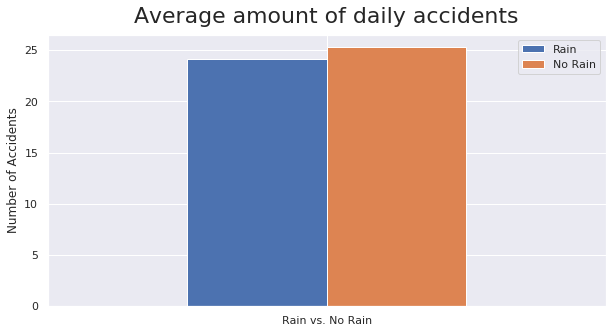

In [29]:
result_df['date'] = result_df['date_time'].apply(getDate)
dfRain = result_df[result_df['rainfall'] > 0].copy()
dfNoRain = result_df[result_df['rainfall'] == 0].copy()
accidentsOnRain = dfRain.groupby('date').size().mean()
accidentsOnNoRain = dfNoRain.groupby('date').size().mean()
d = {'Rain': [accidentsOnRain,accidentsOnNoRain]}

index = ['Rain vs. No Rain']
dfPlot = pd.DataFrame({'Rain': accidentsOnRain,
                   'No Rain': accidentsOnNoRain}, index=index)
plot = dfPlot.plot.bar(rot=0,figsize=(10,5))

plot.set_ylabel('Number of Accidents')
plot.set_title("Average amount of daily accidents", y=1.02, fontsize=22)

Though there is only a slight difference, we can see that there are more accidents on days without rain than days with rain.  This can possibly be attributed to the fact that individuals may be less likely to travel unnecessarily because of the inclimate weather and the drivers that do opt to do so  are more cautious in the rain, which in turn decreases the likelihood of drivers getting into accidents. The reduction of driver volume combined with increased alertness could explain the unexpected result of this graph. 

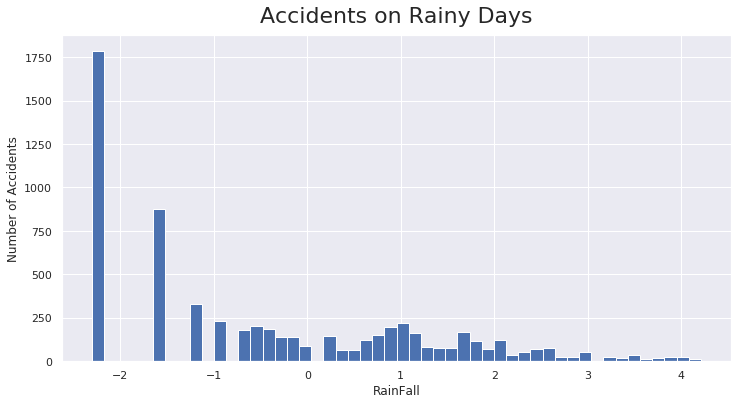

In [30]:
plt.figure(figsize = (12,6))
dfRain['rainfall10'] = dfRain['rainfall']
dfRain['rainfall10'] = np.log(dfRain['rainfall'])
#Majority of accidents that happen on rainy days is where rain is low, not when rainfall is high
rainGraph = dfRain['rainfall10'].hist(bins=50)
rainGraph.set_ylabel('Number of Accidents')
rainGraph.set_xlabel('RainFall')
rainGraph.set_title("Accidents on Rainy Days", y=1.02, fontsize=22);
#not in inches in millimeters used log function to give a better distribution for the graph

In this graph we wanted to see how many accidents occurred on rainy days compared to non rainy days. The values on the X-axis represents how wet it was. Negative numbers mean that there was less rain while positive numbers mean that there is more rain. As shown in the graph, there are more accidents when there is less rain than where there is more rain. This can be attributed to the slick roads when rain first starts or when there is not much rain to begin with. When there is more rain, drivers are more likely to drive safer leading to less accidents, but when there is less rain or when rain begins, drivers do not fully realize how dangerous the roads can be and drive as they would if there was no rain, leading to more accidents.

### Daily Average Temperature and Accidents

(0.0, 38.0)

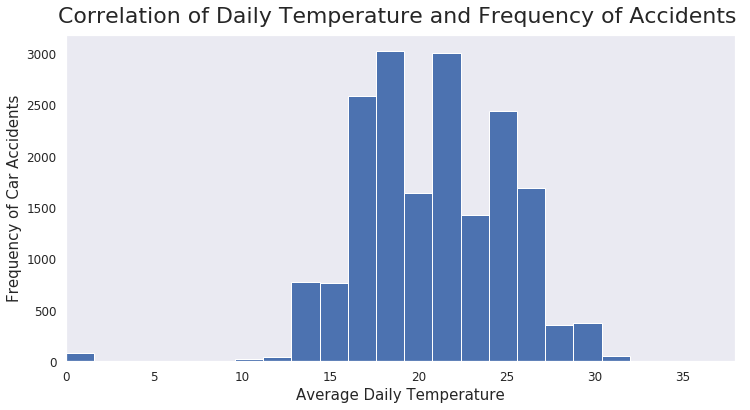

In [31]:
plt.figure(figsize = (12,6))
result_df['temp'].hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Average Daily Temperature", fontsize=15)
plt.ylabel("Frequency of Car Accidents",fontsize=15)
plt.title("Correlation of Daily Temperature and Frequency of Accidents ", y=1.02, fontsize=22);
plt.xlim([0.0,38.0])

We did not find enough evidence to demonstrate that there is a significant correlation of car accidents in San Diego and the daily average temperature. We assumed that as temperature increases, there would be a higher likelihood of someone being involved in a car accident. Our theory for this was that people tend to drive more aggressively as the temperature increases, causing a higher likelihood of accidents and reckless driving. In the histogram above we compared the frequency of car accidents in San Diego with the daily average temperature and we notice no significant skewed distribution which tells us that there is evidence to say that there is no correlation between the average daily temperature and likelihood of car accidents in San Diego. There is an outlier at zero degrees C, where there is a surprising number of accidents which was unexpected since the number of accidents drops off as the temperature gets cooler.

### Accidents on and near Holidays

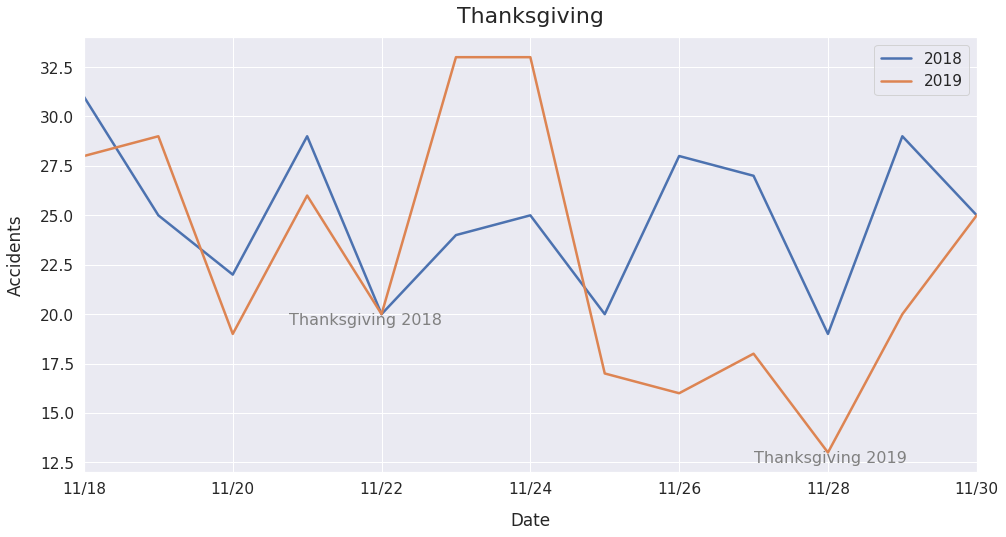

In [32]:
#group dates and count the number of accidents in each date
dates = result_df.groupby('date').size()
#then convert to a dataframe
dates = dates.to_frame()
dates.sort_values(by = 'date')

tg2018 = dates.loc['11/18/2018':'11/30/2018'].copy()
tg2018 =tg2018[~tg2018.index.str.contains("2019" or "2020")]
#tg stands for thanskgiving day
tg2019 = dates.loc['11/18/2019':'11/30/2019'].copy()
tg2019 = tg2019[~tg2019.index.str.contains("2018" or "2020")]
#dropping rows that appear in the dataset more than twice
tg2019 = tg2019.drop('11/3/2019')
tg2019 = tg2019.drop('11/2/2019')
tg2018 = tg2018.drop('11/2/2018')
tg2018 = tg2018.drop('11/3/2018')

tg2018['dateRow'] = tg2018.index.map(grabDatePrefix)
tg2019['dateRow'] = tg2018.index.map(grabDatePrefix)
tgDataFrame = pd.merge(tg2018, tg2019, on='dateRow', how='inner')
tgDataFrame = tgDataFrame.set_index('dateRow')
tgDataFrame = tgDataFrame.rename(columns={"0_x": "2018", "0_y": "2019"})

#plotting of the graph
sns.set(font_scale=1.4)
tgDataFrame.plot(figsize=(16, 8), linewidth=2.5)
plt.xlabel("Date", labelpad=15)
plt.ylabel("Accidents", labelpad=15)
style = dict(size=16, color='gray')
plt.text(2.75, 19.5,'Thanksgiving 2018',**style)
plt.text(9, 12.5,'Thanksgiving 2019',**style)
plt.title("Thanksgiving", y=1.02, fontsize=22);

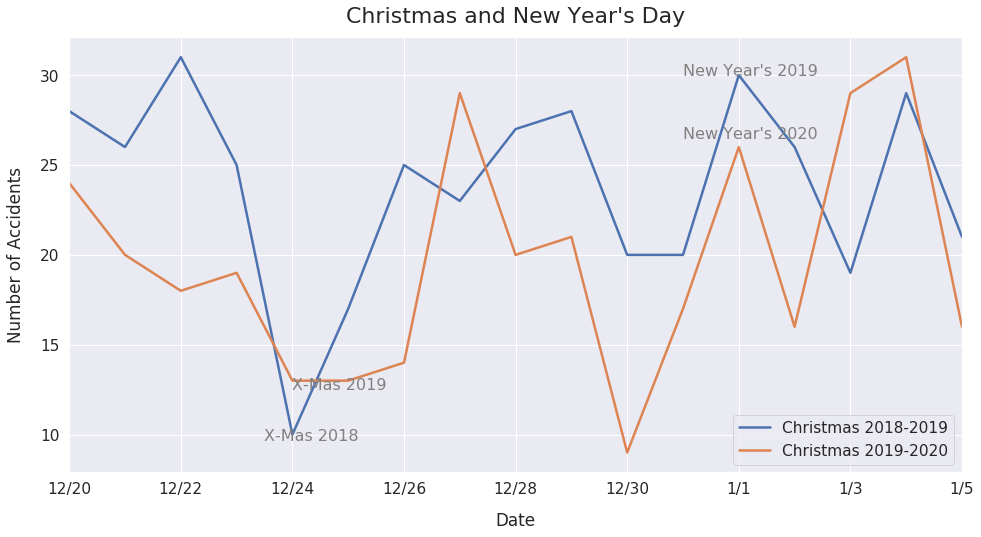

In [33]:
winter2018 = dates.loc['12/20/2018':'12/31/2018'].copy()
winter2018 = winter2018[~winter2018.index.str.contains("2019" or "2020")]
winter2018part2 = dates.loc['1/1/2019':'1/5/2019']
winter2018part2 = winter2018part2[~winter2018part2.index.str.contains("2020")]
winter2018part2 = winter2018part2[winter2018part2.index.str.len() < 9]
winter2018 = winter2018.append(winter2018part2)
#Code is slightly complex  due to how groupby sorted the dates

#making a new df from series data and dropping if year does not match, boolean logic used
winter2019 = dates.loc['12/20/2019':'12/31/2019'].copy()
winter2019 = winter2019[~winter2019.index.str.contains("2018" or "2020")]
winter2019part2 = dates.loc['1/1/2020':'1/5/2020']
winter2019part2 = winter2019part2[~winter2019part2.index.str.contains("2019")]
#if len is less than 9 it is a date at the very beginning of the year
winter2019part2 = winter2019part2[winter2019part2.index.str.len() < 9]
winter2019 = winter2019.append(winter2019part2)
#drop rows that fall through conditions
winter2018 = winter2018.drop('12/3/2018')
winter2019 = winter2019.drop('12/3/2019')
#grabbing the prefix 'ie: 1/1' from index to use later
winter2018['dateRow'] = winter2018.index.map(grabDatePrefix)
winter2019['dateRow'] = winter2019.index.map(grabDatePrefix)

wiData = pd.merge(winter2018, winter2019, on='dateRow', how='inner')
#merge data on the prefix to align graph
wiData = wiData.set_index('dateRow')
#set index to dateRow and rename columns in graph
wiData = wiData.rename(columns={"0_x": "Christmas 2018-2019", "0_y": "Christmas 2019-2020"})

sns.set(font_scale=1.4)
wiData.plot(figsize=(16, 8), linewidth=2.5)
plt.xlabel("Date", labelpad=15)
plt.ylabel("Number of Accidents", labelpad=15)
style = dict(size=16, color='gray')
#plotting a point
plt.text(3.5, 9.65,'X-Mas 2018',**style)
plt.text(4, 12.5,'X-Mas 2019',**style)

plt.text(11, 30,'New Year\'s 2019',**style)
plt.text(11, 26.5,'New Year\'s 2020',**style)

plt.title("Christmas and New Year\'s Day", y=1.02, fontsize=22);

Next, we wanted to compare the number of accidents between 2018 and 2019 on three major US holidays, Christmas/New Years and Thanksgiving,  to see if there were any significant differences. After creating two line charts with both 2018 and 2019 traffic data, we were able to see that there was a significant spike in accidents on the days leading up to Christmas, and Thanksgiving. There was also a significant spike on New Years Day. These spikes are consistent across both 2018 and 2019. This could be attributed to the increase of travel and population density that occurs during these holidays, as well as the drinking culture that surrounds New Years, especially in a larger city like San Diego.

In [16]:
dateLR = result_df.groupby('date').size()
dateLR = dateLR.to_frame()
#performed groubpy to get number of accidents on a date
dateLR['DateLR'] = dateLR.index
dateLR['DateLR'] = pd.to_datetime(dateLR.DateLR)

dateLR = dateLR.sort_values(by=['DateLR'])
dateLR.drop(['DateLR'],axis=1)
grabINFO = result_df.copy()
grabINFO = grabINFO.set_index('date')
dateLR['rain'] = np.nan
dateLR['temp'] = np.nan
for index, row in dateLR.iterrows():
    v1 = grabINFO.loc[str(index)]['rainfall'].iloc[0]
    if v1 > 0:
        v1 = 1
    else:
        v1 = 0
    dateLR['rain'].loc[index] = v1
    v2 = grabINFO.loc[str(index)]['temp'].iloc[0]
    dateLR['temp'].loc[index] = v2

dateLR = dateLR.rename(columns={0: "accidentCount"})

In [17]:
#prepared for linear regression
dateLR

,accidentCount,DateLR,rain,temp
date,,,,
1/18/2018,15,2018-01-18,0.0,21.0
1/19/2018,26,2018-01-19,1.0,16.0
1/20/2018,19,2018-01-20,1.0,14.0
1/21/2018,23,2018-01-21,0.0,15.0
1/22/2018,31,2018-01-22,0.0,17.0
...,...,...,...,...
1/19/2020,16,2020-01-19,0.0,20.0
1/20/2020,10,2020-01-20,1.0,16.0
1/21/2020,13,2020-01-21,1.0,14.0


### Rain and the Frequency of Accidents

In [18]:
outcome_1, predictors_1 = patsy.dmatrices('accidentCount ~ rain', dateLR)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:          accidentCount   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.532
Date:                Mon, 16 Mar 2020   Prob (F-statistic):             0.0108
Time:                        21:43:04   Log-Likelihood:                -2324.7
No. Observations:                 736   AIC:                             4653.
Df Residuals:                     734   BIC:                             4663.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.2704      0.264     95.648      0.0

In this figure we wanted to see if rain was correlated with traffic accidents. We conducted an ANOVA on the dataset and got a f-statistic of 6.532. This value by itself doesn’t mean much, so we calculated the P-value, which turned out to be 0.011. Since 0.011 < 0.05 we can say that there is correlation between rain and traffic accidents in San Diego, and the results can be considered statistically significant.

### Temperature and Frequency of Accidents

In [19]:
outcome_1, predictors_1 = patsy.dmatrices('accidentCount ~ temp', dateLR)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:          accidentCount   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     22.90
Date:                Mon, 16 Mar 2020   Prob (F-statistic):           2.06e-06
Time:                        21:43:05   Log-Likelihood:                -2314.0
No. Observations:                 735   AIC:                             4632.
Df Residuals:                     733   BIC:                             4641.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.9792      1.041     19.195      0.0

The figure above represents a weak correlation between temperature and the frequency of accidents that occured on a daily temperature. We noticed that correlation between these variables is non-existing since our P-value was very close to 0. We were unable to provide sufficient evidence to conclude that car accidents in San Diego increase as the average daily temperature increases. Our prediction that daily average temperature would affect people’s driving was not supported since we found in our models that there is no significant correlation between the two variables.

### Temperature, Rain, and the Frequency of Accidents

In [20]:
outcome_1, predictors_1 = patsy.dmatrices('accidentCount ~ rain + temp', dateLR)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:          accidentCount   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     12.36
Date:                Mon, 16 Mar 2020   Prob (F-statistic):           5.24e-06
Time:                        21:43:05   Log-Likelihood:                -2313.1
No. Observations:                 735   AIC:                             4632.
Df Residuals:                     732   BIC:                             4646.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.5815      1.133     18.163      0.0

Here we wanted to figure out if there was a correlation between temperature, rainfall and traffic accidents in San Diego. After inputting the data into the algorithm we got that the P-value for rain and traffic accidents is 0.180, which was larger than when we calculated if rain correlated with traffic accidents. The P-value for temperature remained the same between this and the previous calculation meaning that there is no significant correlation between temperature and traffic accidents. Based on these results, we can conclude that there is no significant correlation between temperature, rainfall and the frequency of traffic accidents in San Diego.

### Lethal Accidents

### Time of Day and the Frequency of Lethal Accidents

In [21]:
result_df['timeLog'] = result_df['date_time'].apply(binaryDayNight)
result_df['killedLog'] = result_df['killed'].apply(killed)
result_df['weatherLog'] = rainfallLog(result_df)
y, X = patsy.dmatrices('killedLog ~ timeLog', result_df, return_type = 'dataframe')
logitfit = sm.Logit(y,X).fit()
print(logitfit.summary())

Optimization terminated successfully.
         Current function value: 0.032329
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              killedLog   No. Observations:                18298
Model:                          Logit   Df Residuals:                    18296
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 Mar 2020   Pseudo R-squ.:                0.004975
Time:                        21:43:35   Log-Likelihood:                -591.56
converged:                       True   LL-Null:                       -594.52
                                        LLR p-value:                   0.01501
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.4881      0.149    -36.739      0.000      -5.781      -5.195
timeLog        0.5015      0.

In [22]:
print(logitfit.conf_int())

                  0         1
Intercept -5.780889 -5.195333
timeLog    0.097673  0.905318


For this section we wanted to figure out if the time of day the accident occurred was correlated to the frequency of lethal accidents. So we used the number of observations and calculated that the P-value is 0.015. Since this value is less than 0.05, this means that the time of day that the accident occurred is correlated to the frequency of lethal accidents. This could be attributed to an increase in inebriated drivers, drowsy or under the influence, at night due to parties or late work hours. In addition the percentage relating to accidents at a time considered night is 90 percent, which means that accidents are likely to happen at night or when it simply is just dark.

### Weather, Time of Day, and the Frequency of Lethal Accidents

In [23]:
result_df['timeLog'] = result_df['date_time'].apply(binaryDayNight)
result_df['killedLog'] = result_df['killed'].apply(killed)
result_df['weatherLog'] = rainfallLog(result_df)
y, X = patsy.dmatrices('killedLog ~ timeLog + weatherLog', result_df, return_type = 'dataframe')
logitfit = sm.Logit(y,X).fit()
print(logitfit.summary())

Optimization terminated successfully.
         Current function value: 0.032325
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              killedLog   No. Observations:                18298
Model:                          Logit   Df Residuals:                    18295
Method:                           MLE   Df Model:                            2
Date:                Mon, 16 Mar 2020   Pseudo R-squ.:                0.005106
Time:                        21:44:08   Log-Likelihood:                -591.48
converged:                       True   LL-Null:                       -594.52
                                        LLR p-value:                   0.04806
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.4584      0.167    -32.773      0.000      -5.785      -5.132
timeLog        0.5013      0.

In [24]:
print(logitfit.conf_int())

                   0         1
Intercept  -5.784814 -5.131953
timeLog     0.097432  0.905084
weatherLog -0.512055  0.341176


Here we wanted to figure out how weather affected the frequency of lethal accidents. We calculated to see if weather and time correlated to lethal accidents. According to the results, lethal accidents are more likely to occur at night and even more so while it is raining. Despite this data, we calculated a P-value of 0.695 for weather and lethal accidents meaning there is no correlation between weather and lethal accidents. These results came as a surprise as it was hypothesized that rain would lead to more lethal accidents due to worse road conditions and decreased visibility.

Text(0.5, 1.02, 'Lethal Accidents When its Raining')

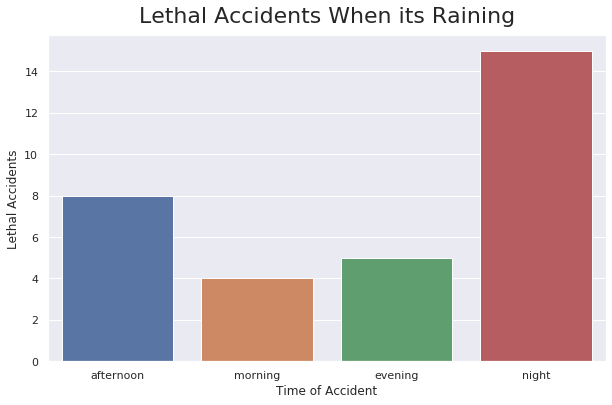

In [34]:
nwDF = result_df[(result_df['killed'] > 0)  & (result_df['rainfall'] > 0)]
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="day/night", data=nwDF)
ax.set_ylabel('Lethal Accidents')
ax.set_xlabel('Time of Accident')
ax.set_title("Lethal Accidents When its Raining", y=1.02, fontsize=22)

## Ethics & Privacy
The dataset is ethical because it is a public domain accessed via formal request from  federal and local agencies, which means that it can be easily verified and open to use. The data protects the privacy of those involved as it does not label specific individuals but rather a general location the accident occurred in. The beat number identifier could be used to track who reported to the scene, however, police records are not open to the public. Additional tracking information such as names and license plates of those involved in accidents are not provided in the dataset, keeping all individuals involved anonymous ergo protecting their privacy. Since we are unable to account for the number of people involved in the accidents, we are unable to assess the severity of each accident. This makes us unable to tell the difference between severe accidents or a small crash.

## Conclusion & Discussion
Based on the data above, we can conclude that most traffic accidents occurred on days where there was no rain. On days where there was rain, most accidents occurred in the afternoon and more lethal accidents occured at night. There is no correlation between average temperature and accidents while there is a correlation between rainfall and accidents, but only at night. There are less accidents on holidays than surrounding days, except for New Years day which saw a significant spike in the number of accidents. Accidents are more likely to happen on roads than freeways and these accidents happen on major roads with lots of daily business. A surprising observation was that there are some areas such as near the airport that are completely void of any traffic accidents. This leads us to conclude that there are many accidents that are either minor in nature or just not reported to the police. Based on the linear regression tests that we conducted we can conclude that there is a correlation between rain and the frequency of traffic accidents and a correlation between the time of day and the frequency of lethal accidents. However we found no correlation between the temperature and the frequency of traffic accidents, no correlation between overall weather and the frequency of traffic accidents. Our hypothesis that rainfall and time of day affected the frequency of traffic accidents in San Diego was supported by the data. Despite this, our hypothesis was incorrect in terms of temperature and our belief that mornings led to more traffic accidents. Temperature was not correlated with the frequency of traffic accidents at all and out of the four times of day on rainy days (morning, afternoon, evening, night), the mornings were the second least likely time to be in an accident, beat only by the evenings where most people would be at home.<br><br>
Limitations: Time is a significant limitation as given more time to delve into the project, more geospatial analysis could have been done; but due to lack of knowledge and resources  as well it was hard to go down that route. Another limiting factor was figuring out  which of the various API’s to use and how to merge information from several API sources into one usable dataset, which kind of got in the way of making progress. A limitation within the dataset itself was the type of information that was present in the dataset. There could be a possible confound in that there may be other law enforcement agencies taking traffic incident reports that were not in the API that we were able to locate and utilize. There was no information about gender or age that could be used to compare. In addition there was also no information about car makes, models or color, no information on the types of pedestrians that may have been involved or whether they were on things such as bicycles or e-scooters or just walking, which may have been useful to delve into and see correlations. We don’t necessarily know if a vehicle was a motorcycle or it was a semi-truck. Since this dataset also comes from traffic accidents that were reported to the police, we can assume that there are other accidents that are not reported which can lead to error in our data. Overall road conditions such as construction, potholes or road markings are not recorded in accident reports as well. These could have been a factor in some of the accidents, but since it was not included in the police report, we were unable to address it despite its inclusion in our hypothesis. In addition, the original dataset itself was missing important information such as weather data as well as exact location and even formatting relative classifiers, building up the dataset to a more proper form was a major challenge.

## Team Contributions
Data Cleaning, Lead Programmer, Conclusion: Karim Dabboussi<br>
Data Formatting, Data Analysis, Ethics, Conclusion: Brent Kimura<br>
Background, Data Analysis: Stjepan Kilic<br>
Data Analysis, Background, Visualizations: Marco Aceves<br>
Data Sourcing, Hypothesis, Ethics, Conclusion: Amanda Bustamante<br>